#### <strong><font color=cornflowerblue>第四次作品:深度學習影像去模糊模型之訓練流程設計與實作 </font></strong>
學號：711331135

姓名：王宣懿

<hr>

#### <strong>作品目標</strong>：本作品旨在建立並訓練一套高效的影像去模糊模型，透過深度學習技術還原模糊影像的清晰度。首先，從資料集（如 T91、Set5、Set14）中讀取清晰圖像，將其裁切成指定大小的小圖塊（patch），並對每個 patch 套用高斯模糊產生對應的模糊版本，形成成對的訓練資料。這些模糊／清晰影像對依據訓練與驗證需求儲存於不同資料夾，作為模型學習的基礎。接著，透過 PyTorch 架構多種影像去模糊模型，結合自定義 Dataset 類別載入資料、設定損失函數與訓練超參數，完成模型訓練與評估流程。本作品亦設計兩階段訓練策略，先以 Set5 與 Set14 等簡單資料集進行預訓練，協助模型學習基礎特徵擷取能力，再以 T91 資料集進行微調，提升模型在真實模糊影像上的表現。最終透過 PSNR 等指標以及視覺化結果，評估模型效能還原品質與實際去模糊效果。











<hr>

#### <strong>載入套件</strong>：

In [1]:
import os
import re
import cv2
import time
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import Deblurring_defs
from Deblurring_defs import  (
    DeblurDataset, DeepResidualUNet, save_decoded_image, psnr
) 

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<hr>
<hr>

#### **<font color=cornflowerblue>資料預處理：</font>**  
建立去模糊模型所需的訓練與驗證資料集，透過影像裁切與模糊處理產生成對的清晰與模糊影像 patch。從數個資料夾（如 T91、Set5、Set14）讀取清晰影像，依指定大小切割成小圖塊，並對每個 patch 套用高斯模糊產生對應的模糊版本。最終，將這些 patch 分別儲存為清晰版本（作為標籤）與模糊版本（作為輸入），並依據訓練與驗證資料來源存入不同資料夾，供後續模型訓練與測試使用。

**檔案來源:** Deblurring_data_preparation.ipynb

<hr>
<hr>

#### **<font color=cornflowerblue>資料訓練並評估影像去模糊模型：</font>**  
本程式建立並訓練多種深度學習模型，以執行影像去模糊任務。模型訓練資料來自已預處理的模糊與清晰影像 patch 資料集（如 T91、Set5、Set14），透過自定義的 Dataset 類別載入資料。接著使用 PyTorch 建構去模糊模型、設定損失函數與超參數，並進行訓練與驗證流程。最後輸出還原後的圖像，並以 PSNR 等指標評估影像重建品質，檢驗模型的實際去模糊效果。

#### (1) 模型訓練參數與資料路徑設定

**注意事項：**
1. IMG_RESIZE = (96, 96)：設定每張圖片統一 resize 成 96x96
2. BATCH_SIZE = 8：每次訓練所使用的圖片批次數量
3. LEARNING_RATE = 1e-4：模型的學習率
4. NUM_EPOCHS = 10：訓練總輪數




In [2]:

DIR_PATH = '../'
IMG_RESIZE =  (96, 96)  # 或直接不用 resize
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10

blur_path = DIR_PATH + 'inputs/T91_blurred_patches'
sharp_path = DIR_PATH + 'inputs/T91_sharp_patches'

image_dir = DIR_PATH + 'outputs/saved_images'
os.makedirs(image_dir, exist_ok=True)


In [ ]:
DIR_PATH = "C:/Users/User/Downloads/DeblurCNN_2025_v1.1" 
# blur/sharp 資料夾
train_blur_path = os.path.join(DIR_PATH, "inputs", "T91_blurred_patches")
train_sharp_path = os.path.join(DIR_PATH, "inputs", "T91_sharp_patches")
val_blur_path = os.path.join(DIR_PATH, "inputs", "VAL_blurred_patches")
val_sharp_path = os.path.join(DIR_PATH, "inputs", "VAL_sharp_patches")

# 正確取得檔名（只保留 .png）
def is_numeric_png(name):
    return isinstance(name, str) and re.fullmatch(r'\d+\.png', name.lower()) is not None

train_image_names = [
    f for f in os.listdir(train_blur_path)
    if is_numeric_png(f)
]

val_image_names = [
    f for f in os.listdir(val_blur_path)
    if is_numeric_png(f)
]
print(" example filename:", train_image_names[0])

# 建立轉換流程
transform_pipeline = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])
excluded = [f for f in os.listdir(train_blur_path) if not is_numeric_png(f)]
print("被排除的檔案：", excluded)

# 建立 Dataset
train_dataset = DeblurDataset(
    blur_path=train_blur_path,
    sharp_path=train_sharp_path,
    image_names=train_image_names,
    patch_size=96,
    transform=transform_pipeline
)

val_dataset = DeblurDataset(
    blur_path=val_blur_path,
    sharp_path=val_sharp_path,
    image_names=val_image_names,
    patch_size=96,
    transform=transform_pipeline
)

# 建立 DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

 example filename: 00000.png
被排除的檔案： []


#### (3) 使用模型訓練與驗證流程
**注意事項：**
1. 模型與設備初始化
- 選擇模型架構 DeepResidualUNet
2. 訓練設定
- Adam 優化器（optimizer）與 MSELoss 作為損失函數（criterion）
- ReduceLROnPlateau 學習率調整器，當驗證損失無進步時，自動將學習率減半。
3. 訓練與驗證迴圈
- 訓練模式 : 依序讀取訓練資料，將模糊影像輸入模型進行預測，並計算預測結果與對應清晰影像之間的損失。隨後進行反向傳播與參數更新，並逐批累加損失以計算該 epoch 的平均訓練損失。
- 評估模式 : 在不更新參數的前提下，依序計算每筆驗證資料的損失與 PSNR，作為影像品質重建的效能指標。最後根據平均驗證損失透過 scheduler.step() 動態調整學習率，提升訓練穩定性與收斂速度。

In [4]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print('Using {} device'.format(device))

model = DeepResidualUNet().to(device)

print(f"Model: {model}")

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

lr = LEARNING_RATE # Learning rate.
optimizer = optim.Adam(model.parameters(), lr=lr)
print(f"Learning rate: {lr}")
print(f"Optimizer: {optimizer}")
# Loss function.
criterion = nn.MSELoss()
print(f"Loss function: {criterion}")

# scheduler is to reduce the learning rate when a monitored metric (like validation loss) stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min',
        patience=3,
        factor=0.5,
        verbose=True

    )
best_psnr = 0
best_loss = float('inf')          # 🔹加這行！
early_stop_counter = 0  

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    

    for blurred, sharp in train_loader:
        blurred, sharp = blurred.to(device), sharp.to(device)
        preds = model(blurred)
        loss = criterion(preds, sharp)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)



    # 每個 epoch 評估 PSNR
    model.eval()
    val_total_loss = 0
    psnr_sum = 0

    with torch.no_grad():
        for val_blur, val_sharp in val_loader:
            val_blur, val_sharp = val_blur.to(device), val_sharp.to(device)
            val_pred = model(val_blur)
            val_loss = criterion(val_pred, val_sharp)  # 🔹 新增 validation loss 計算
            val_total_loss += val_loss.item()
            psnr_score = psnr(val_sharp, val_pred)
            psnr_sum += psnr_score

    avg_val_loss = val_total_loss / len(val_loader)
    avg_psnr = psnr_sum / len(val_loader)

    # 🔻 scheduler 根據 validation loss 調整
    scheduler.step(avg_val_loss)

    # 🔸 儲存最佳模型（以 PSNR 為基準）
    if avg_psnr > best_psnr:
        best_psnr = avg_psnr
        torch.save(model.state_dict(), "best_model.pth")


Using cuda device
Model: DeepResidualUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (res_block): ResidualBlock(
    (block): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (up): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (skip_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (dec1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU

#### (4) 檢查並載入預訓練權重以繼續訓練


In [6]:

# resume training if weights are present.
DIR_PATH = '../'  # 或你實際的資料夾路徑
WEIGHTS = os.path.join(DIR_PATH, 'outputs', 'pre_trained_model.pt')
if os.path.exists(WEIGHTS):
    print('Weights file found. Resuming training...')

    checkpoint = torch.load(WEIGHTS)
    print("Resuming the model state...")
    model.load_state_dict(checkpoint['model_state_dict'])
    pre_trained_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch: {pre_trained_epoch}")
    # Load the optimizer state if available. may not be good idea to resume.
    print("Resuming the optimizer state...")
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    pre_trained_epoch = 0
    print('No pre-trained file found. Starting training from scratch...')
print(f"Current Model: {model}")


Weights file found. Resuming training...
Resuming the model state...
Resuming training from epoch: 80
Resuming the optimizer state...
Current Model: DeepResidualUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (res_block): ResidualBlock(
    (block): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (up): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (skip_conv): Conv2d(64, 128, kernel_size=(1, 1), st

#### (5) 將模糊與清晰影像配對並切分訓練／驗證資料集

In [7]:
gauss_blur = os.listdir(blur_path)
gauss_blur.sort()
sharp = os.listdir(sharp_path)
sharp.sort()
from sklearn.model_selection import train_test_split

x_blur = sorted([f for f in os.listdir(blur_path) if f.endswith('.png')])
y_sharp = sorted([f for f in os.listdir(sharp_path) if f.endswith('.png')])

assert len(x_blur) == len(y_sharp), "模糊與清晰圖片數量不一致"

x_train, x_val, y_train, y_val = train_test_split(x_blur, y_sharp, test_size=0.1, random_state=42)

transform = transforms.ToTensor()

train_data = DeblurDataset(blur_path, sharp_path, x_train, transform=transform)
val_data = DeblurDataset(blur_path, sharp_path, x_val, transform=transform)

trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=1, shuffle=False)
print(f"Train data instances: {len(x_train)}")
print(f"Validation data instances: {len(x_val)}")


Train data instances: 351
Validation data instances: 39


#### (6) 定義單一訓練週期（Epoch）之模型訓練流程
**注意事項：**
- 包含資料送入模型、誤差計算與反向傳播，以及評估損失與影像品質指標。

In [8]:
def fit(model, dataloader, epoch, optimizer, device):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0

    for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        blur_image, sharp_image = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(blur_image)

        loss = criterion(outputs, sharp_image)  # 改成使用 combined_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_psnr += psnr(sharp_image, outputs)

    train_loss = running_loss / len(dataloader.dataset)
    train_psnr = running_psnr / len(dataloader)
    print(f"Train Loss: {train_loss:.5f} - Train PSNR: {train_psnr:.2f} dB")

    return train_loss, train_psnr


#### (7) 定義模型驗證流程與影像輸出函式
**注意事項：**
- 不更新權重，僅回傳損失與影像品質評估指標（PSNR），並選擇性儲存部分輸出影像供觀察使用。

In [9]:
def validate(model, dataloader, epoch, device):
    model.eval() #設定模型為驗證模式
    running_loss = 0.0 #初始化損失與 PSNR 統計
    running_psnr = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            blur_image, sharp_image = data[0].to(device), data[1].to(device)
            outputs = model(blur_image)

            loss = criterion(outputs, sharp_image)  # 也改成 combined_loss

            running_loss += loss.item()
            running_psnr += psnr(sharp_image, outputs)

            # 下面保存圖片的程式碼視需求保留或刪除
            if epoch == 0 and i == int((len(val_data) / dataloader.batch_size) - 2):
                save_decoded_image(sharp_image.cpu().data, name=f"{image_dir}/sharp{epoch}.jpg", size=IMG_RESIZE)
                save_decoded_image(blur_image.cpu().data, name=f"{image_dir}/blur{epoch}.jpg", size=IMG_RESIZE)
                save_decoded_image(outputs.cpu().data, name=f"{image_dir}/deblurred{epoch}.jpg", size=IMG_RESIZE)
            if i == int((len(val_data) / dataloader.batch_size) - 2):
               save_decoded_image(outputs.cpu().data, name=f"{image_dir}/val_deblurred{epoch}.jpg", size=IMG_RESIZE)

    val_loss = running_loss / len(dataloader.dataset)
    val_psnr = running_psnr / len(dataloader)
    print(f"Val Loss: {val_loss:.5f} - Val PSNR: {val_psnr:.2f} dB")

    return val_loss, val_psnr

#### (8) 完整訓練流程與模型儲存機制（含損失與 PSNR 記錄）


In [9]:

train_loss, val_loss = [], [] #初始化紀錄用列表與計時器
train_psnr, val_psnr = [], []
start_time = time.time()
epochs = NUM_EPOCHS

for epoch in range(epochs): #訓練與驗證迴圈
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = fit(model, trainloader, epoch, optimizer, device)
    val_epoch_loss, val_epoch_psnr = validate(model, valloader, epoch, device)

    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)

    scheduler.step(val_epoch_loss)

end_time = time.time()
print(f"Took {((end_time-start_time)/60):.3f} minutes to train")
print('Saving model...')

# save the model
cumulative_epochs = epochs + pre_trained_epoch
torch.save({
    'epoch': cumulative_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_psnr': train_psnr,
    'val_psnr': val_psnr
}, WEIGHTS)

print(f"Model saved as {WEIGHTS}")

Epoch 1 of 10


  0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 44/44 [00:13<00:00,  3.14it/s]


Train Loss: 0.00950 - Train PSNR: 17.94 dB


100%|██████████| 39/39 [00:00<00:00, 46.14it/s]


Val Loss: 0.08000 - Val PSNR: 20.59 dB
Epoch 2 of 10


100%|██████████| 44/44 [00:13<00:00,  3.23it/s]


Train Loss: 0.00863 - Train PSNR: 18.27 dB


100%|██████████| 39/39 [00:00<00:00, 54.18it/s]


Val Loss: 0.07616 - Val PSNR: 20.61 dB
Epoch 3 of 10


100%|██████████| 44/44 [00:13<00:00,  3.23it/s]


Train Loss: 0.00940 - Train PSNR: 17.94 dB


100%|██████████| 39/39 [00:00<00:00, 53.65it/s]


Val Loss: 0.08531 - Val PSNR: 20.72 dB
Epoch 4 of 10


100%|██████████| 44/44 [00:13<00:00,  3.21it/s]


Train Loss: 0.00948 - Train PSNR: 18.11 dB


100%|██████████| 39/39 [00:00<00:00, 53.69it/s]


Val Loss: 0.07682 - Val PSNR: 20.55 dB
Epoch 5 of 10


100%|██████████| 44/44 [00:13<00:00,  3.20it/s]


Train Loss: 0.00851 - Train PSNR: 18.30 dB


100%|██████████| 39/39 [00:00<00:00, 47.90it/s]


Val Loss: 0.07328 - Val PSNR: 20.64 dB
Epoch 6 of 10


100%|██████████| 44/44 [00:14<00:00,  3.14it/s]


Train Loss: 0.00885 - Train PSNR: 18.07 dB


100%|██████████| 39/39 [00:00<00:00, 46.12it/s]


Val Loss: 0.05866 - Val PSNR: 21.53 dB
Epoch 7 of 10


100%|██████████| 44/44 [00:14<00:00,  3.10it/s]


Train Loss: 0.00917 - Train PSNR: 18.05 dB


100%|██████████| 39/39 [00:00<00:00, 50.01it/s]


Val Loss: 0.07203 - Val PSNR: 20.73 dB
Epoch 8 of 10


100%|██████████| 44/44 [00:14<00:00,  3.03it/s]


Train Loss: 0.00938 - Train PSNR: 17.91 dB


100%|██████████| 39/39 [00:00<00:00, 42.22it/s]


Val Loss: 0.07891 - Val PSNR: 20.56 dB
Epoch 9 of 10


100%|██████████| 44/44 [00:15<00:00,  2.84it/s]


Train Loss: 0.00895 - Train PSNR: 18.21 dB


100%|██████████| 39/39 [00:00<00:00, 42.29it/s]


Val Loss: 0.06373 - Val PSNR: 20.49 dB
Epoch 10 of 10


100%|██████████| 44/44 [00:13<00:00,  3.19it/s]


Train Loss: 0.00884 - Train PSNR: 18.30 dB


100%|██████████| 39/39 [00:00<00:00, 50.57it/s]

Val Loss: 0.06672 - Val PSNR: 20.72 dB
Took 2.483 minutes to train
Saving model...
Model saved as ../outputs\pre_trained_model.pt


<hr>
<hr>

#### <strong>結果呈現：</strong>
#### **<font color=cornflowerblue>第一題：</font>**  
#### (1) 載入預訓練模型並接續訓練 10 個 Epoch

In [11]:
model = DeepResidualUNet().to(device)

# 路徑設定
weights_path = os.path.join(DIR_PATH, "outputs", "pre_trained_model.pt")

# 載入 checkpoint
checkpoint = torch.load(weights_path, map_location=device)

# 模型與 optimizer 狀態復原
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 已訓練的 epoch 數
pre_trained_epoch = checkpoint.get('epoch', 0)
print(f"Resumed from epoch {pre_trained_epoch}")

# 只保留正確長度的紀錄
additional_epochs = 10
start_time = time.time()
train_loss, val_loss = [], [] #初始化紀錄用列表與計時器
train_psnr, val_psnr = [], []
start_time = time.time()
epochs = NUM_EPOCHS

for epoch in range(pre_trained_epoch, pre_trained_epoch + additional_epochs):
    print(f"\n Epoch {epoch + 1}/{pre_trained_epoch + additional_epochs}")

    train_epoch_loss, train_epoch_psnr = fit(model, trainloader, epoch, optimizer, device)
    val_epoch_loss, val_epoch_psnr = validate(model, valloader, epoch, device)

    # 正確地記錄每個 epoch 的結果
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_psnr.append(val_epoch_psnr)

    scheduler.step(val_epoch_loss)

end_time = time.time()
cumulative_epoch = pre_trained_epoch + additional_epochs
print(f"Training completed in {(end_time - start_time) / 60:.2f} minutes")

# 儲存新的模型狀態
torch.save({
    'epoch': cumulative_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_psnr': train_psnr,
    'val_psnr': val_psnr
}, weights_path)
print(f" Model saved at epoch {cumulative_epoch}")

Resumed from epoch 80

 Epoch 81/90


100%|██████████| 44/44 [00:13<00:00,  3.19it/s]


Train Loss: 0.00924 - Train PSNR: 18.08 dB


100%|██████████| 39/39 [00:00<00:00, 47.74it/s]


Val Loss: 0.06945 - Val PSNR: 21.05 dB

 Epoch 82/90


100%|██████████| 44/44 [00:13<00:00,  3.20it/s]


Train Loss: 0.00923 - Train PSNR: 18.03 dB


100%|██████████| 39/39 [00:00<00:00, 52.94it/s]


Val Loss: 0.06117 - Val PSNR: 21.25 dB

 Epoch 83/90


100%|██████████| 44/44 [00:13<00:00,  3.21it/s]


Train Loss: 0.00961 - Train PSNR: 17.81 dB


100%|██████████| 39/39 [00:00<00:00, 52.68it/s]


Val Loss: 0.07917 - Val PSNR: 20.58 dB

 Epoch 84/90


100%|██████████| 44/44 [00:13<00:00,  3.20it/s]


Train Loss: 0.00900 - Train PSNR: 18.09 dB


100%|██████████| 39/39 [00:00<00:00, 54.03it/s]


Val Loss: 0.05980 - Val PSNR: 21.05 dB

 Epoch 85/90


100%|██████████| 44/44 [00:13<00:00,  3.18it/s]


Train Loss: 0.00897 - Train PSNR: 18.07 dB


100%|██████████| 39/39 [00:00<00:00, 52.22it/s]


Val Loss: 0.06243 - Val PSNR: 21.09 dB

 Epoch 86/90


100%|██████████| 44/44 [00:13<00:00,  3.16it/s]


Train Loss: 0.00848 - Train PSNR: 18.38 dB


100%|██████████| 39/39 [00:00<00:00, 50.82it/s]


Val Loss: 0.06926 - Val PSNR: 21.05 dB

 Epoch 87/90


100%|██████████| 44/44 [00:13<00:00,  3.17it/s]


Train Loss: 0.00855 - Train PSNR: 18.41 dB


100%|██████████| 39/39 [00:00<00:00, 54.14it/s]


Val Loss: 0.06105 - Val PSNR: 21.47 dB

 Epoch 88/90


100%|██████████| 44/44 [00:13<00:00,  3.21it/s]


Train Loss: 0.00835 - Train PSNR: 18.33 dB


100%|██████████| 39/39 [00:00<00:00, 50.08it/s]


Val Loss: 0.07088 - Val PSNR: 20.75 dB

 Epoch 89/90


100%|██████████| 44/44 [00:14<00:00,  3.11it/s]


Train Loss: 0.00907 - Train PSNR: 17.95 dB


100%|██████████| 39/39 [00:00<00:00, 53.38it/s]


Val Loss: 0.07294 - Val PSNR: 20.85 dB

 Epoch 90/90


100%|██████████| 44/44 [00:13<00:00,  3.22it/s]


Train Loss: 0.00912 - Train PSNR: 18.12 dB


100%|██████████| 39/39 [00:00<00:00, 54.41it/s]

Val Loss: 0.05989 - Val PSNR: 21.69 dB
Training completed in 2.43 minutes
 Model saved at epoch 90


##### 1) 訓練與驗證損失/PSNR 變化圖繪製

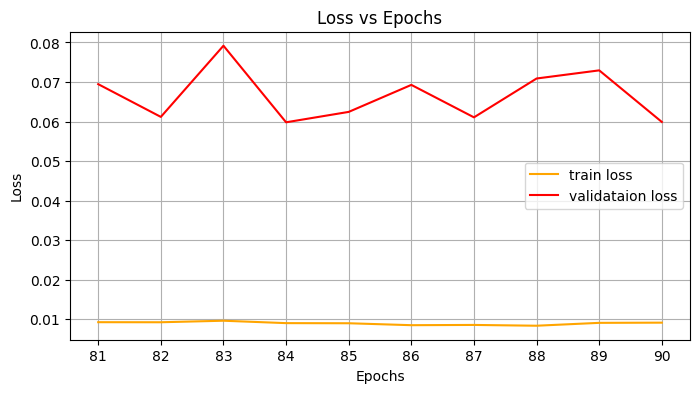

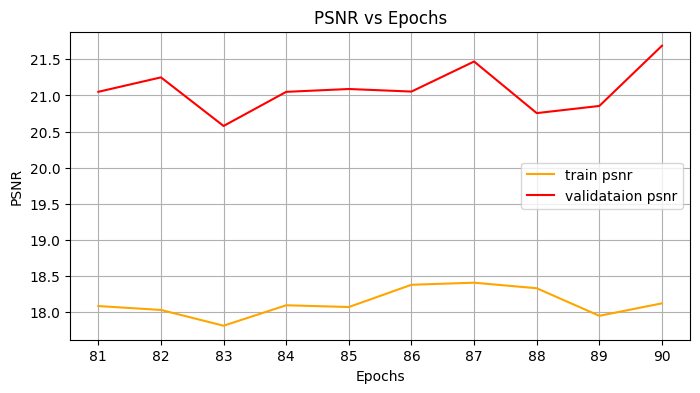

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')

num_points = len(train_loss)
num_ticks = 10 if num_points >= 10 else num_points
tick_positions = np.linspace(0, num_points-1, num_ticks, dtype=int)
tick_labels = [pre_trained_epoch + i + 1 for i in tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels)

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig(DIR_PATH + 'outputs/loss.png')
plt.show()
# save the model to disk
plt.figure(figsize=(8, 4))
plt.plot(train_psnr, color='orange', label='train psnr')
plt.plot(val_psnr, color='red', label='validataion psnr')
plt.xticks(ticks=tick_positions, labels=tick_labels)
plt.title('PSNR vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.grid()
plt.savefig(DIR_PATH + 'outputs/psnr.png')
plt.show()

#### (2) 再次接續預訓練模型，進行10個Epoch的訓練

In [13]:
model = DeepResidualUNet().to(device)

# 路徑設定
weights_path = os.path.join(DIR_PATH, "outputs", "pre_trained_model.pt")

# 載入 checkpoint
checkpoint = torch.load(weights_path, map_location=device)

# 模型與 optimizer 狀態復原
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 已訓練的 epoch 數
pre_trained_epoch = checkpoint.get('epoch', 0)
print(f"Resumed from epoch {pre_trained_epoch}")

# 只保留正確長度的紀錄
additional_epochs = 10
train_loss, val_loss = [], [] #初始化紀錄用列表與計時器
train_psnr, val_psnr = [], []
start_time = time.time()
epochs = NUM_EPOCHS

for epoch in range(pre_trained_epoch, pre_trained_epoch + additional_epochs):
    print(f"\n Epoch {epoch + 1}/{pre_trained_epoch + additional_epochs}")

    train_epoch_loss, train_epoch_psnr = fit(model, trainloader, epoch, optimizer, device)
    val_epoch_loss, val_epoch_psnr = validate(model, valloader, epoch, device)

    # 正確地記錄每個 epoch 的結果
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_psnr.append(val_epoch_psnr)

    scheduler.step(val_epoch_loss)

end_time = time.time()
cumulative_epoch = pre_trained_epoch + additional_epochs
print(f"Training completed in {(end_time - start_time) / 60:.2f} minutes")

# 儲存新的模型狀態
torch.save({
    'epoch': cumulative_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_psnr': train_psnr,
    'val_psnr': val_psnr
}, weights_path)
print(f" Model saved at epoch {cumulative_epoch}")

Resumed from epoch 90

 Epoch 91/100


100%|██████████| 44/44 [00:13<00:00,  3.19it/s]


Train Loss: 0.00949 - Train PSNR: 17.99 dB


100%|██████████| 39/39 [00:00<00:00, 54.67it/s]


Val Loss: 0.07998 - Val PSNR: 20.70 dB

 Epoch 92/100


100%|██████████| 44/44 [00:13<00:00,  3.19it/s]


Train Loss: 0.00905 - Train PSNR: 18.08 dB


100%|██████████| 39/39 [00:00<00:00, 49.08it/s]


Val Loss: 0.06632 - Val PSNR: 21.49 dB

 Epoch 93/100


100%|██████████| 44/44 [00:13<00:00,  3.16it/s]


Train Loss: 0.00907 - Train PSNR: 18.05 dB


100%|██████████| 39/39 [00:00<00:00, 53.10it/s]


Val Loss: 0.07213 - Val PSNR: 21.35 dB

 Epoch 94/100


100%|██████████| 44/44 [00:13<00:00,  3.21it/s]


Train Loss: 0.00960 - Train PSNR: 17.88 dB


100%|██████████| 39/39 [00:00<00:00, 55.90it/s]


Val Loss: 0.04761 - Val PSNR: 21.65 dB

 Epoch 95/100


100%|██████████| 44/44 [00:14<00:00,  3.04it/s]


Train Loss: 0.00914 - Train PSNR: 18.06 dB


100%|██████████| 39/39 [00:00<00:00, 55.16it/s]


Val Loss: 0.06905 - Val PSNR: 21.40 dB

 Epoch 96/100


100%|██████████| 44/44 [00:13<00:00,  3.23it/s]


Train Loss: 0.00922 - Train PSNR: 18.00 dB


100%|██████████| 39/39 [00:00<00:00, 55.82it/s]


Val Loss: 0.06839 - Val PSNR: 20.74 dB

 Epoch 97/100


100%|██████████| 44/44 [00:15<00:00,  2.89it/s]


Train Loss: 0.00917 - Train PSNR: 18.02 dB


100%|██████████| 39/39 [00:00<00:00, 53.17it/s]


Val Loss: 0.05265 - Val PSNR: 21.72 dB

 Epoch 98/100


100%|██████████| 44/44 [00:13<00:00,  3.15it/s]


Train Loss: 0.00916 - Train PSNR: 18.20 dB


100%|██████████| 39/39 [00:00<00:00, 51.00it/s]


Val Loss: 0.06771 - Val PSNR: 20.87 dB

 Epoch 99/100


100%|██████████| 44/44 [00:14<00:00,  2.94it/s]


Train Loss: 0.00859 - Train PSNR: 18.32 dB


100%|██████████| 39/39 [00:01<00:00, 26.93it/s]


Val Loss: 0.08391 - Val PSNR: 20.54 dB

 Epoch 100/100


100%|██████████| 44/44 [00:13<00:00,  3.21it/s]


Train Loss: 0.00966 - Train PSNR: 17.80 dB


100%|██████████| 39/39 [00:00<00:00, 55.61it/s]

Val Loss: 0.07204 - Val PSNR: 21.13 dB
Training completed in 2.49 minutes
 Model saved at epoch 100


##### 1) 訓練與驗證損失/PSNR 變化圖繪製

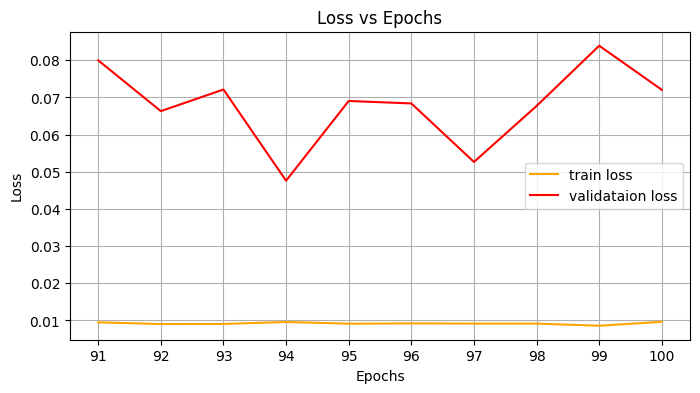

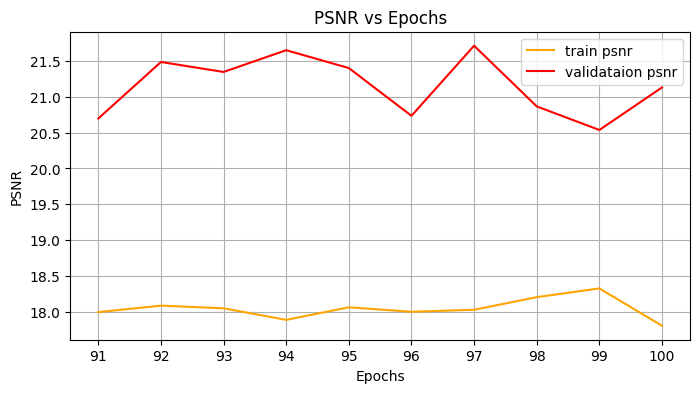

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')

num_points = len(train_loss)
num_ticks = 10 if num_points >= 10 else num_points
tick_positions = np.linspace(0, num_points-1, num_ticks, dtype=int)
tick_labels = [pre_trained_epoch + i + 1 for i in tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels)

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig(DIR_PATH + 'outputs/loss.png')
plt.show()
# save the model to disk
plt.figure(figsize=(8, 4))
plt.plot(train_psnr, color='orange', label='train psnr')
plt.plot(val_psnr, color='red', label='validataion psnr')
plt.xticks(ticks=tick_positions, labels=tick_labels)
plt.title('PSNR vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.grid()
plt.savefig(DIR_PATH + 'outputs/psnr.png')
plt.show()


<hr>

#### **<font color=cornflowerblue>第二題：</font>**  
#### (1) 以 Set5 測試集為例，將清晰圖片進行模糊處理後，輸入至訓練完成的 DeepResidualUNet 模型進行去模糊推論，並計算去模糊結果相對於原圖的 PSNR 表現，以視覺化與量化方式評估模型效能。

Using cuda device


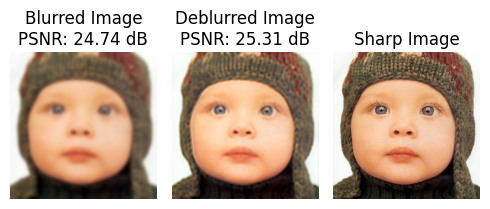

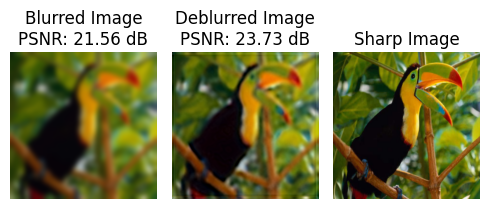

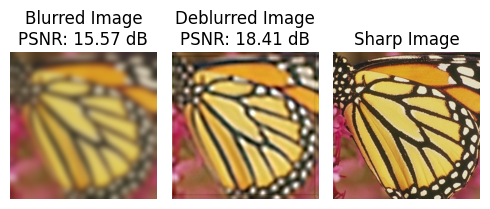

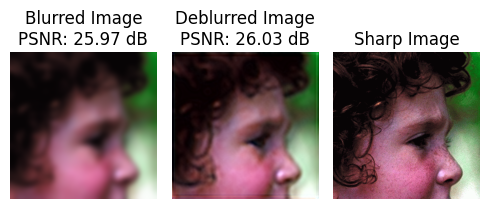

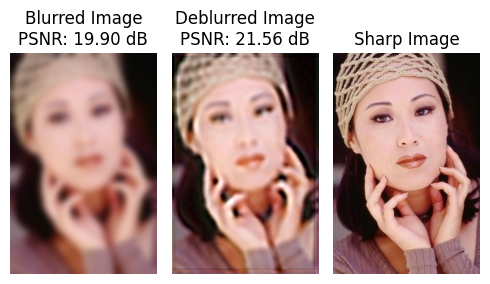

In [5]:

# 設定裝置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

# 設定資料夾路徑
DIR_PATH = "../"
input_sharp_dir = os.path.join(DIR_PATH, "inputs", "Set5")
val_sharp_dir = os.path.join(DIR_PATH, "inputs", "VAL_sharp_patches")
val_blur_dir = os.path.join(DIR_PATH, "inputs", "VAL_blurred_patches")

# 確保輸出資料夾存在
os.makedirs(val_sharp_dir, exist_ok=True)
os.makedirs(val_blur_dir, exist_ok=True)

# 讀取所有圖片
image_files = [f for f in os.listdir(input_sharp_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# 載入模型
model = DeepResidualUNet().to(device)
weights_path = os.path.join(DIR_PATH, "outputs", "pre_trained_model.pt")
checkpoint = torch.load(weights_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# 迴圈處理每張圖片
for image_file in image_files:
    # 讀取清晰圖片
    sharp_path = os.path.join(input_sharp_dir, image_file)
    sharp = cv2.imread(sharp_path)
    if sharp is None:
        print(f"⚠️ 無法讀取圖片：{sharp_path}")
        continue
    sharp = cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB)

    # 轉 tensor
    transform = transforms.ToTensor()
    sharp_tensor = transform(sharp).unsqueeze(0).to(device)

    # 模糊處理
    blur = cv2.GaussianBlur(sharp, (31, 31), 0)
    blur_path = os.path.join(val_blur_dir, image_file)
    cv2.imwrite(blur_path, cv2.cvtColor(blur, cv2.COLOR_RGB2BGR))  # 儲存模糊圖片

    # 轉 tensor
    blur_tensor = transform(blur).unsqueeze(0).to(device)

    # 去模糊推論
    with torch.no_grad():
        deblurred_tensor = model(blur_tensor)

    # 計算 PSNR
    psnr_blur = psnr(sharp_tensor, blur_tensor)
    psnr_deblur = psnr(sharp_tensor, deblurred_tensor)

    # 轉 numpy 並 clip
    img_blur = np.clip(blur_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1)
    img_deblur = np.clip(deblurred_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1)
    img_sharp = np.clip(sharp_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1)

    # 顯示結果
    fig, ax = plt.subplots(1, 3, figsize=(5, 3))
    ax[0].imshow(img_blur)
    ax[0].set_title(f'Blurred Image\nPSNR: {psnr_blur:.2f} dB')
    ax[0].axis('off')

    ax[1].imshow(img_deblur)
    ax[1].set_title(f'Deblurred Image\nPSNR: {psnr_deblur:.2f} dB')
    ax[1].axis('off')

    ax[2].imshow(img_sharp)
    ax[2].set_title('Sharp Image')
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

#### (1) 以 Set19 測試集為例，將清晰圖片進行模糊處理後，輸入至訓練完成的 DeepResidualUNet 模型進行去模糊推論，並計算去模糊結果相對於原圖的 PSNR 表現，以視覺化與量化方式評估模型效能。

Using cuda device


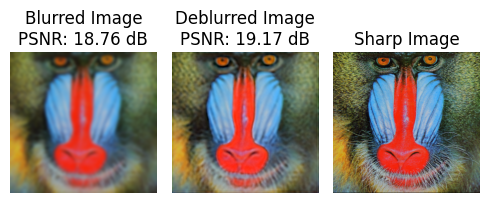

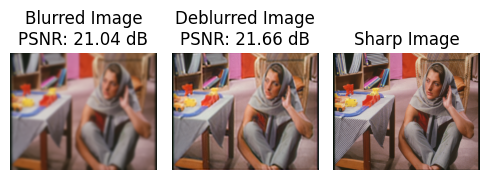

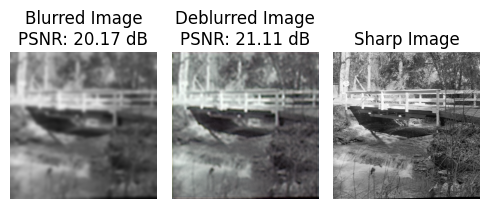

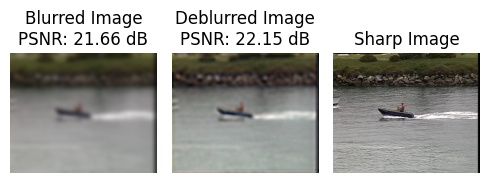

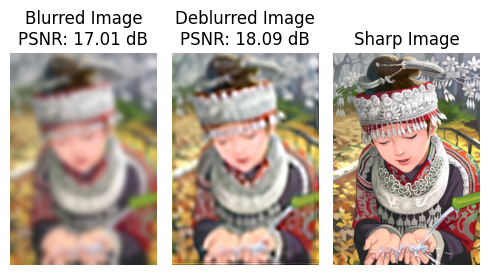

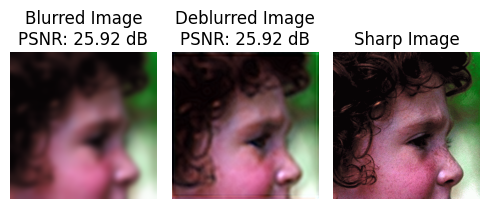

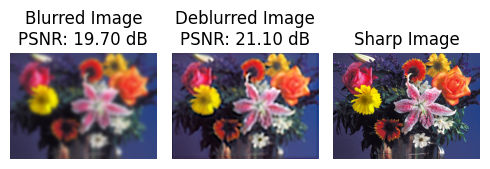

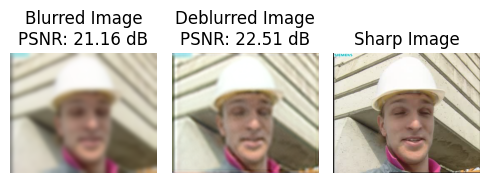

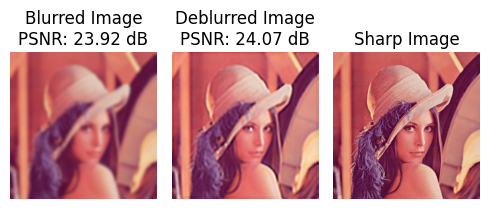

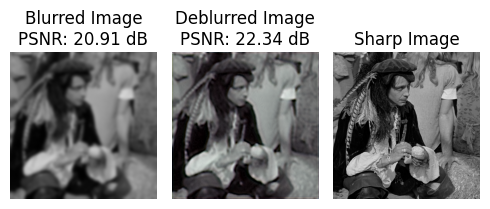

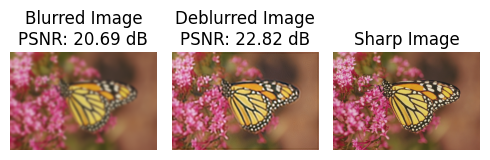

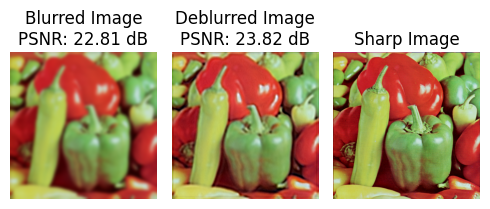

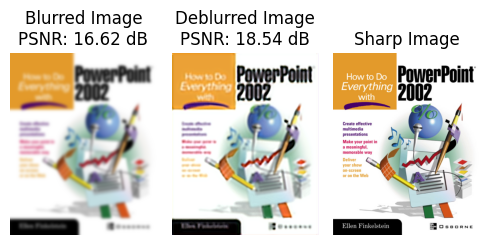

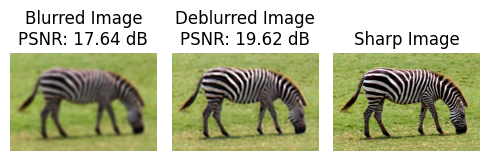

In [ ]:

# 設定裝置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

# 設定資料夾路徑
DIR_PATH = "../"
input_sharp_dir = os.path.join(DIR_PATH, "inputs", "Set14")
val_sharp_dir = os.path.join(DIR_PATH, "inputs", "VAL_sharp_patches")
val_blur_dir = os.path.join(DIR_PATH, "inputs", "VAL_blurred_patches")

# 確保輸出資料夾存在
os.makedirs(val_sharp_dir, exist_ok=True)
os.makedirs(val_blur_dir, exist_ok=True)

# 讀取所有圖片
image_files = [f for f in os.listdir(input_sharp_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# 載入模型
model = DeepResidualUNet().to(device)
weights_path = os.path.join(DIR_PATH, "outputs", "pre_trained_model.pt")
checkpoint = torch.load(weights_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# 迴圈處理每張圖片
for image_file in image_files:
    # 讀取清晰圖片
    sharp_path = os.path.join(input_sharp_dir, image_file)
    sharp = cv2.imread(sharp_path)
    if sharp is None:
        print(f"⚠️ 無法讀取圖片：{sharp_path}")
        continue
    sharp = cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB)
  
    # 轉 tensor
    transform = transforms.ToTensor()
    sharp_tensor = transform(sharp).unsqueeze(0).to(device)

    # 模糊處理
    blur = cv2.GaussianBlur(sharp, (31, 31), 0)
    blur_path = os.path.join(val_blur_dir, image_file)
    cv2.imwrite(blur_path, cv2.cvtColor(blur, cv2.COLOR_RGB2BGR))  # 儲存模糊圖片
    
    # 轉 tensor
    blur_tensor = transform(blur).unsqueeze(0).to(device)
    
    if sharp_tensor.shape[2:] != blur_tensor.shape[2:]:
        print(f"Resizing sharp and blur tensors to match sizes.")
        blur_tensor = F.interpolate(blur_tensor, size=sharp_tensor.shape[2:], mode='bilinear', align_corners=False)
    
    # 去模糊推論
    with torch.no_grad():
        deblurred_tensor = model(blur_tensor)

    # 計算 PSNR
    psnr_blur = psnr(sharp_tensor , blur_tensor)
    psnr_deblur = psnr(sharp_tensor , deblurred_tensor)

    # 轉 numpy 並 clip
    img_blur = np.clip(blur_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1)
    img_deblur = np.clip(deblurred_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1)
    img_sharp = np.clip(sharp_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1)
    
    
    # 顯示結果
    fig, ax = plt.subplots(1, 3, figsize=(5, 3))
    ax[0].imshow(img_blur)
    ax[0].set_title(f'Blurred Image\nPSNR: {psnr_blur:.2f} dB')
    ax[0].axis('off')

    ax[1].imshow(img_deblur)
    ax[1].set_title(f'Deblurred Image\nPSNR: {psnr_deblur:.2f} dB')
    ax[1].axis('off')

    ax[2].imshow(img_sharp)
    ax[2].set_title('Sharp Image')
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()


<hr>

#### **<font color=cornflowerblue>第三題：</font>**  
#### (1) 以名畫拾穗為例，將清晰圖片進行模糊處理後，輸入至訓練完成的 DeepResidualUNet 模型進行去模糊推論，並計算去模糊結果相對於原圖的 PSNR 表現，以視覺化與量化方式評估模型效能。

Using cuda device


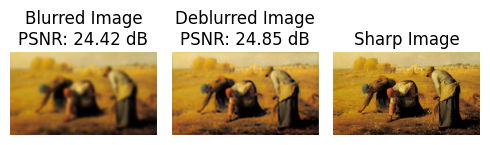

In [3]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# 模型與裝置設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

model = DeepResidualUNet().to(device)

# 載入訓練好的模型權重
weights_path = "../outputs/pre_trained_model.pt"
checkpoint = torch.load(weights_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# 指定要處理的單張圖片檔名
image_path = "C:/Users/User/Downloads/DeblurCNN_2025_v1.1/inputs/painting1/1.jpg"

# 讀取原始清晰圖片
sharp = cv2.imread(image_path)
if sharp is None:
    raise FileNotFoundError(f"⚠️ 無法讀取圖片：{image_path}")
sharp = cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB)

# 模糊處理
blur = cv2.GaussianBlur(sharp, (31, 31), 0)

# 轉換為 Tensor
transform = transforms.ToTensor()
sharp_tensor = transform(sharp).unsqueeze(0).to(device)
blur_tensor = transform(blur).unsqueeze(0).to(device)

# 去模糊推論
with torch.no_grad():
    deblurred_tensor = model(blur_tensor)

# 計算 PSNR
psnr_blur = psnr(sharp_tensor, blur_tensor)
psnr_deblur = psnr(sharp_tensor, deblurred_tensor)

# 還原為圖片格式
img_blur = np.clip(blur_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1)
img_deblur = np.clip(deblurred_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1)
img_sharp = np.clip(sharp_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1)

# 顯示結果
fig, ax = plt.subplots(1, 3, figsize=(5, 3))
ax[0].imshow(img_blur)
ax[0].set_title(f'Blurred Image\nPSNR: {psnr_blur:.2f} dB')
ax[0].axis('off')

ax[1].imshow(img_deblur)
ax[1].set_title(f'Deblurred Image\nPSNR: {psnr_deblur:.2f} dB')
ax[1].axis('off')

ax[2].imshow(img_sharp)
ax[2].set_title('Sharp Image')
ax[2].axis('off')

plt.tight_layout()
plt.show()

<hr>
<hr>

#### **<font color=cornflowerblue>模型選擇與損失函數分析：</font>** 

在本研究中，我嘗試設計並比較了多種深度學習影像去模糊模型，涵蓋不同結構設計與特徵強化策略。所實作的模型包括：

- ResidualSEBlock 架構為核心的 DeepDeblurCNN：結合殘差學習與通道注意力（SEBlock），強化模糊特徵擷取。

- DeblurSuperResCNN：融合超解析結構概念，透過特徵串接與多層捲積提升細節恢復。

- DeblurHybridCNN：採用 encoder-residual-decoder 架構，有效整合上下文與重建資訊。

- ModerateDeblurCNN：設計為較簡潔但具有殘差連接的淺層網路，兼具效能與可運算性。

為進行模型效能比較，我以 PSNR 為主要客觀指標，並搭配 butterfly 圖（視覺化各模型在不同影像上的 PSNR 分佈）呈現模型整體穩定性與表現差異。最終，我選擇表現最佳且穩定性高的模型作為最終架構，其不僅在平均 PSNR 上表現優異，在個別圖像上也展現出更平衡的還原品質。

#### **<font color=cornflowerblue>訓練流程比較：學生檔案 vs. 老師檔案：</font>** 

| 項目                         | 學生檔案                                                | 老師檔案                                                  | 說明與註解 |
|------------------------------|--------------------------------------------------------|----------------------------------------------------------|------------|
| 訓練目標                  | 包含預訓練 + 微調階段                           | 獨立訓練流程，無前段預訓練設計                           | 學生檔案內部即分兩階段訓練，老師檔案則單一訓練流程 |
|  預訓練資料集              | Set5 + Set19 | 無                                                      | 學生檔案透過這兩組簡單清晰圖像學習基礎模糊特徵 |
| 微調資料集                | T91（T91_blurred_patches / T91_sharp_patches）     | General100（sharp） + gaussian_blurred（blur）     | 學生檔案是針對 T91 補丁圖做 fine-tuning，老師檔案則為整圖 |
| 訓練架構                  | DeepResidualUNet()                                  | DeblurCNN_RES() or DeblurSuperResCNN()              | 模型結構不同，學生檔案為殘差型 UNet，老師檔案為輕量深層 CNN |
| 預訓練階段功能說明        | 幫助模型在小且單純的 Set5/19 上學會邊緣與模糊擷取能力 | —                                                        | 建立基本視覺感知能力的啟動器 |
|  微調階段功能說明          | 精練模型於大量 patch（T91）上針對細節與局部模糊處理能力 | 直接訓練模型處理真實模糊整圖（General100 + Gaussian）   | 一個為補丁細化路線，一個為高分辨率還原 |
| train/test split 處理方式 | 以 train_test_split 切分 T91，做 9:1 微調驗證       | 同樣以 train_test_split 切分 General100 做驗證         | 雙方都使用 sklearn 切分資料，保證公平驗證 |
| 模型權重保存方式          | best_model.pth（根據最高 PSNR）                     | pre_trained_model.pt（最後 epoch 儲存）               | 學生檔案儲存最強結果，老師檔案儲存最後結果 |
| Scheduler 與調整策略     | ReduceLROnPlateau（val loss 無改善即降低 LR）        | 相同                                                      | 老師檔案耐心值（patience）設為 5，學生檔案 為 3 |
| 是否 resume 訓練          |  有設定 resume 接續訓練                             | 有設定 resume 接續訓練                               | 設計一致 |



